In [130]:
import warnings
warnings.filterwarnings("ignore")

import os
import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import torch
import keras
from keras import models
from keras import layers
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
def extract_features(file_name):
    """
    Extracts 193 chromatographic features from sound file. 
    including: MFCC's, Chroma_StFt, Melspectrogram, Spectral Contrast, and Tonnetz
    NOTE: this extraction technique changes the time series nature of the data
    """
    audio_data, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(audio_data))
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    # More possible features to add
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X, ), sr=sample_rate).T,axis=0)
#     spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate).T, axis=0)
#     spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate).T, axis=0)
#     rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate).T, axis=0)
#     zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)

    features = []
    features.extend(mfcc) # 40 = 40
    features.extend(chroma) # 12 = 52
    features.extend(mel) # 128 = 180
    features.extend(contrast) # 7 = 187
    
    
#     features.extend(tonnetz) # 6 = 193
#     features.extend(spec_cent)
#     features.extend(spec_bw)
#     features.extend(rolloff)
#     features.extend(zcr)

    return np.array(features)

In [90]:
def load_all_wav_files(load_urbansound=False,
                       load_birds=False,
                       load_kaggle=False):
    #THIS WILL TAKE A WHILE!!!!!
    all_data = []
    all_labels = []
    #UltraSound8K
    if load_urbansound:
        print("loading Ultrasound8k")
        # Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
        metadata = pd.read_csv(".data/UrbanSound8K/metadata/UrbanSound8K.csv")
        for root, dirs, files in os.walk("./data/UrbanSound8K"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
    #       # This is in here for quick tests - only loads first Ultrasound8k folder (instead of all of them)
            if len(all_data) > 0: 
                break
            for idx, file in enumerate(files):
                if file.endswith('.wav'):
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    fname = os.path.join(root, file)
                    features = extract_features(fname)
                    label = metadata[metadata.slice_file_name == file]["class"].tolist()[0]
                    all_data.append(features)
                    all_labels.append(label)


    if load_birds:
        print("Loading birds")
        # Data Source: http://dcase.community/challenge2018/task-bird-audio-detection
        # Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
        for root, dirs, files in os.walk("./data/warblrb10k_public_wav/train/hasbird"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for file in files:
                if(len(all_data) % 100 == 0):
                    print(str(len(all_data)))
                if file.endswith('.wav'):
                    audio_data, _sampling_rate = librosa.load(os.path.join(root, file))
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append("bird")
    
    if load_kaggle:
        print("Loading Kaggle")
        # Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
        metadata = pd.read_csv("./data/environmental-sound-classification-50/esc50.csv")
        #for root, dirs, files in os.walk("./data/environmental-sound-classification-50/"):
        for file in os.listdir("./data/environmental-sound-classification-50/audio"):
            fname = "./data/environmental-sound-classification-50/audio/"+file
#            for file in files:
#                 print(file)
#                 print(metadata[metadata.filename == file])
            if file.endswith('.wav'):
                label = metadata[metadata.filename == file]["category"].tolist()[0]
                animals=["cat", "chirping_birds","cow","crickets","crow","dog","frog","hen","insects","pig","rooster","sheep"]
                if label in animals:
                    #label_idx = animals.index(label)
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
    #                         fname = os.path.join(root, file)
    #                         features = extract_feature(fname)
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append(label)

    return np.array(all_data), np.array(all_labels)

In [91]:
all_data, all_labels = load_all_wav_files(False, False, True)

Loading Kaggle
0
100
200
300
400


In [92]:
print(all_data)

[[-600.96826172    4.73532915   -8.54689312 ...   14.79261244
    14.78421694   15.92695327]
 [-194.22547913    3.4621582   -60.11297226 ...   18.99719835
    20.78417121   40.62037977]
 [-119.30892181   89.46111298    4.37540817 ...   17.38128703
    15.64357827   32.22306691]
 ...
 [-209.72244263  124.27468872  -54.13316345 ...   19.85338961
    20.84353333   33.20814996]
 [-146.85836792   93.48636627  -36.22686386 ...   18.40760239
    18.93029409   28.40796094]
 [-491.03067017    5.41973495  -30.22523308 ...   16.76519362
    17.38881342   25.76792721]]


In [93]:
print(all_data.shape)
classes = list(set(all_labels))
n_classes = len(classes)
print(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels])

(480, 187)
['crickets', 'rooster', 'dog', 'cow', 'hen', 'insects', 'frog', 'chirping_birds', 'cat', 'crow', 'pig', 'sheep']


In [111]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(all_data, numeric_labels, test_size=0.2, shuffle=True)

In [112]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(336, 187)
(336,)
(144, 187)
(144,)


In [114]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

In [131]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [132]:
history = model.fit(x_train, y_train, epochs=500, batch_size=100)

Epoch 1/500
336/336 [==============================] - 0s 298us/step - loss: 0.2921 - accuracy: 0.9375
Epoch 2/500
336/336 [==============================] - 0s 33us/step - loss: 0.2163 - accuracy: 0.9226
Epoch 3/500
336/336 [==============================] - 0s 33us/step - loss: 0.0911 - accuracy: 0.9554
Epoch 4/500
336/336 [==============================] - 0s 33us/step - loss: 0.0407 - accuracy: 0.9911
Epoch 5/500
336/336 [==============================] - 0s 36us/step - loss: 0.0177 - accuracy: 1.0000
Epoch 6/500
336/336 [==============================] - 0s 33us/step - loss: 0.0609 - accuracy: 0.9851
Epoch 7/500
336/336 [==============================] - 0s 36us/step - loss: 0.0141 - accuracy: 1.0000
Epoch 8/500
336/336 [==============================] - 0s 33us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 9/500
336/336 [==============================] - 0s 36us/step - loss: 0.0077 - accuracy: 1.0000
Epoch 10/500
336/336 [==============================] - 0s 33us/step - loss: 0.00

336/336 [==============================] - 0s 30us/step - loss: 1.4393e-04 - accuracy: 1.0000
Epoch 154/500
336/336 [==============================] - 0s 36us/step - loss: 1.4293e-04 - accuracy: 1.0000
Epoch 155/500
336/336 [==============================] - 0s 36us/step - loss: 1.4184e-04 - accuracy: 1.0000
Epoch 156/500
336/336 [==============================] - 0s 36us/step - loss: 1.4248e-04 - accuracy: 1.0000
Epoch 157/500
336/336 [==============================] - 0s 36us/step - loss: 1.4074e-04 - accuracy: 1.0000
Epoch 158/500
336/336 [==============================] - 0s 33us/step - loss: 1.3897e-04 - accuracy: 1.0000
Epoch 159/500
336/336 [==============================] - 0s 33us/step - loss: 1.3817e-04 - accuracy: 1.0000
Epoch 160/500
336/336 [==============================] - 0s 36us/step - loss: 1.3712e-04 - accuracy: 1.0000
Epoch 161/500
336/336 [==============================] - 0s 33us/step - loss: 1.3596e-04 - accuracy: 1.0000
Epoch 162/500
336/336 [===================

Epoch 229/500
336/336 [==============================] - 0s 33us/step - loss: 8.6781e-05 - accuracy: 1.0000
Epoch 230/500
336/336 [==============================] - 0s 30us/step - loss: 8.6095e-05 - accuracy: 1.0000
Epoch 231/500
336/336 [==============================] - 0s 33us/step - loss: 8.5704e-05 - accuracy: 1.0000
Epoch 232/500
336/336 [==============================] - 0s 36us/step - loss: 8.5062e-05 - accuracy: 1.0000
Epoch 233/500
336/336 [==============================] - 0s 36us/step - loss: 8.4686e-05 - accuracy: 1.0000
Epoch 234/500
336/336 [==============================] - 0s 33us/step - loss: 8.3963e-05 - accuracy: 1.0000
Epoch 235/500
336/336 [==============================] - 0s 33us/step - loss: 8.2919e-05 - accuracy: 1.0000
Epoch 236/500
336/336 [==============================] - 0s 33us/step - loss: 8.5411e-05 - accuracy: 1.0000
Epoch 237/500
336/336 [==============================] - 0s 36us/step - loss: 8.1274e-05 - accuracy: 1.0000
Epoch 238/500
336/336 [=====

Epoch 380/500
336/336 [==============================] - 0s 33us/step - loss: 4.1679e-05 - accuracy: 1.0000
Epoch 381/500
336/336 [==============================] - 0s 36us/step - loss: 4.1404e-05 - accuracy: 1.0000
Epoch 382/500
336/336 [==============================] - 0s 30us/step - loss: 4.0998e-05 - accuracy: 1.0000
Epoch 383/500
336/336 [==============================] - 0s 30us/step - loss: 4.0644e-05 - accuracy: 1.0000
Epoch 384/500
336/336 [==============================] - 0s 30us/step - loss: 4.0264e-05 - accuracy: 1.0000
Epoch 385/500
336/336 [==============================] - 0s 36us/step - loss: 4.0014e-05 - accuracy: 1.0000
Epoch 386/500
336/336 [==============================] - 0s 33us/step - loss: 3.9808e-05 - accuracy: 1.0000
Epoch 387/500
336/336 [==============================] - 0s 33us/step - loss: 3.9426e-05 - accuracy: 1.0000
Epoch 388/500
336/336 [==============================] - 0s 33us/step - loss: 3.9182e-05 - accuracy: 1.0000
Epoch 389/500
336/336 [=====

In [133]:
test_loss, test_acc = model.evaluate(x_test,y_test)


144/144 [==============================] - 0s 174us/step


In [134]:
print('test_acc: ',test_acc)

test_acc:  0.5763888955116272


In [135]:
y_predictions = model.predict(x_test)

In [136]:
y_pred = np.argmax(y_predictions, axis=1)

In [137]:
y_pred

array([11, 11, 10,  1,  4,  4, 10,  6, 11,  8,  8,  7,  1,  9,  8,  7,  4,
       10,  9, 10,  6,  2, 10,  5,  0,  7,  1,  2,  3,  3,  2,  6,  8,  4,
        9,  2,  5,  6,  3,  1,  2,  4,  0, 10,  5,  0,  7,  9, 11, 10,  9,
       10,  4,  4, 11, 11,  2,  6,  9,  5, 11, 11, 11,  9,  1, 11, 11,  6,
       10,  6,  2,  8, 10,  8,  4, 10,  1,  2, 10,  1,  4,  7,  2,  9,  3,
        0,  9,  3,  1, 11,  7, 10,  7, 11,  2,  1, 10,  2,  7,  7, 10, 10,
       10, 10,  5,  2,  2,  5,  3,  5, 11,  8,  6,  5,  1,  4,  2,  9, 11,
        2,  4, 10, 10,  7,  2,  7,  6,  5,  7,  5,  9,  5,  4,  3,  2, 10,
        8,  1, 10,  9,  5, 10,  9,  8], dtype=int64)

In [138]:
y_test

array([11, 11,  3,  1,  0,  1, 10,  6, 10,  8,  1,  7,  9,  6,  1,  7,  4,
       10,  9, 10,  6,  4,  7,  2,  0,  0,  1,  1,  5,  3,  4,  2,  7,  4,
       11,  2, 10,  6,  3,  6,  3,  4,  0,  7,  5,  0,  7,  4, 11, 10,  0,
       10,  4,  4, 11, 11,  2,  6,  9,  4, 11, 11, 11,  7,  1, 11,  3,  6,
        3,  6,  2,  8, 10,  8,  4, 11,  9,  4,  3,  6,  4,  7,  1,  9,  3,
        0,  9,  3,  1, 11,  0, 10,  0,  1,  8,  8, 10,  2,  7,  6,  3,  3,
        3,  3,  5,  2,  4,  3,  3,  5, 11, 11,  6,  5,  1,  3,  6,  9,  9,
        1, 10,  7,  3,  7,  8,  7, 10,  5,  7,  3,  0,  5,  4,  8,  2,  3,
        8,  1, 10,  9,  5, 10,  9,  0])

In [139]:
cm = confusion_matrix(y_test, y_pred)

In [140]:
cm

array([[ 4,  0,  0,  0,  1,  0,  0,  3,  1,  2,  0,  0],
       [ 0,  6,  3,  0,  1,  0,  0,  0,  2,  0,  0,  1],
       [ 0,  0,  6,  0,  0,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  5,  1,  2,  0,  0,  0,  0,  9,  1],
       [ 0,  0,  4,  0,  8,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  7,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  1,  0,  0,  0,  7,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  1,  1,  3,  0],
       [ 0,  1,  2,  1,  0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  7,  0,  1],
       [ 0,  0,  0,  0,  1,  1,  1,  0,  0,  0, 10,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1, 11]], dtype=int64)

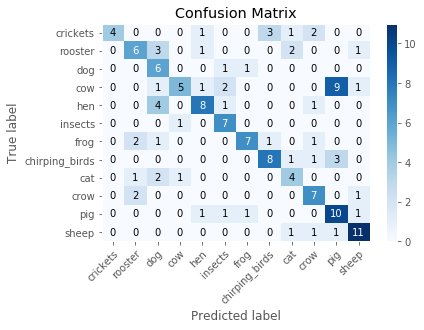

In [141]:
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes,
       yticklabels=classes,
       title="Confusion Matrix",
       ylabel='True label',
       xlabel='Predicted label')
ax.set_ylim(len(classes)-0.5, -0.5)
ax.set_aspect('auto')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.grid(None)
plt.show()

In [126]:
history.history

{'loss': [30.487433819543746,
  11.380974287078494,
  5.979367557026091,
  3.9684563818432035,
  2.5676065995579673,
  2.1024710663727353,
  1.921869668222609,
  1.7092182962667375,
  1.407591686362312,
  1.2343076098532904,
  1.1271768843843823,
  1.0162999161652155,
  0.9433700825486865,
  0.8923613961253848,
  0.8312419127850306,
  0.7736996774162564,
  0.7357381922858102,
  0.7005579656078702,
  0.6551017243237722,
  0.6300785676354453,
  0.5758603527432397,
  0.5575988601361003,
  0.5165056753016654,
  0.48727135005451383,
  0.45626569184518995,
  0.4414731767915544,
  0.4160233583478701,
  0.3989962030734335,
  0.38002904965764,
  0.36609093383664176,
  0.35167888480992543,
  0.33609873411201296,
  0.3202945511965525,
  0.31308576375955627,
  0.2748821329857622,
  0.2923749474187692,
  0.2733272227148215,
  0.25479758176065626,
  0.24889939349322093,
  0.23352513426826113,
  0.22964087714041984,
  0.2056849364723478,
  0.1994904363084407,
  0.19982786086343585,
  0.18397236455764

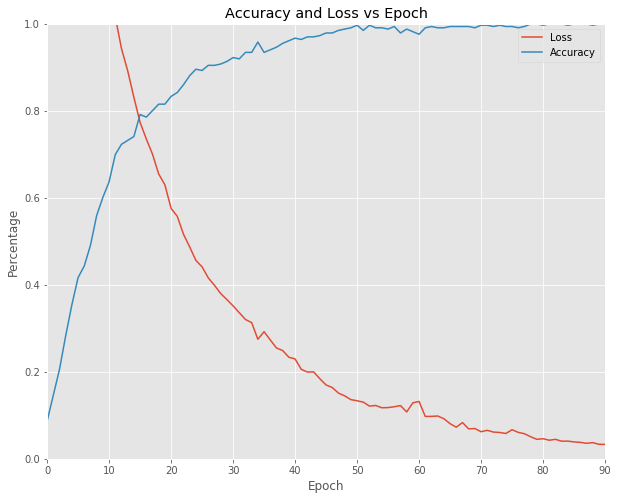

In [127]:
fig = plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['accuracy'], label="Accuracy")
plt.axis([0,90,0,np.max(history.history['accuracy'])])
plt.title("Accuracy and Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Percentage")
plt.legend()
plt.show()